
# QAOA for Max-Cut (Extended)

**Author:** I adapted my earlier demo to better match the reproduction needs of the paper I studied.  
**What I changed (high level):**
- I added **global seeding** for reproducibility.
- I introduced a **config section** so I (and others) can easily toggle important choices.
- I made it easy to **sweep over p (layers)** and **multiple random graph instances**.
- I can now compile to a **square-grid coupling map** and **record circuit depth** after transpilation.
- I added an **optional Aer noise model** (simple, configurable).
- I report **approximation ratio**, **success probability** for the optimal cut, **depth**, and a **time-to-solution** estimate.
- I added **rich comments** and **explanatory text cells** throughout, using “I” where appropriate.



## Environment & Requirements

I wrote this notebook to run with commonly used Python quantum stacks. You may need to install some packages, e.g.:
```bash
pip install qiskit qiskit-aer networkx matplotlib numpy
# optional (if available in your env):
pip install pysat==0.1.8 scipy
```
> If `scipy` isn't available, I automatically fall back to a simple random search optimizer.
> If `pysat` isn't available, I fall back to brute force for small `n`.



## 1. Config — I keep all knobs here

I try to make all experimental choices tweakable from one place. The defaults are chosen so this notebook runs quickly on a laptop.


In [1]:

import math, random, itertools, statistics as stats
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional

import numpy as np

# plotting
import matplotlib.pyplot as plt

# graphs
import networkx as nx

# qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError

# optional classical solvers / optimizers
try:
    from pysat.solvers import RC2
    from pysat.formula import WCNF
    HAS_PYSAT = True
except Exception:
    HAS_PYSAT = False

try:
    from scipy.optimize import minimize
    HAS_SCIPY = True
except Exception:
    HAS_SCIPY = False

# ----------------- Global Config ----------------- #
SEED = 42                     # I seed everything
random.seed(SEED)
np.random.seed(SEED)

# Experiment sizes
N_LIST = [6, 8, 10]           # node sizes to try
P_LIST = [1, 2, 4]            # QAOA depth p values
NUM_INSTANCES = 5             # how many random graphs per n

# Shots & optimizer
SHOTS = 4096                  # sampling shots per expectation eval
NUM_RANDOM_STARTS = 3         # multi-start optimizer attempts
MAX_EVALS_PER_START = 50      # cap function evals per start (approx; depends on optimizer)

# Backend / transpilation
USE_GRID_ROUTING = True       # if True, compile to a square grid
GRID_DIMS = (4, 4)            # grid dimensions (rows, cols) - adjust to fit max n
TRANSPILE_OPT_LVL = 3
BASIS_GATES = ["rz", "sx", "x", "cx"]

# Noise
USE_NOISE = True              # toggle noise model on/off
ONE_QUBIT_ERROR = 1e-3        # depolarizing prob for 1Q ops
TWO_QUBIT_ERROR = 1e-2        # depolarizing prob for 2Q ops
READOUT_ERROR = 0.02          # symmetric readout error

# Time-to-solution model (very rough, for illustration)
T_PREP = 1e-4                 # seconds of per-circuit overhead/prep
T_1Q = 2e-7                   # seconds per 1Q gate
T_2Q = 5e-7                   # seconds per 2Q gate
T_MEAS = 4e-5                 # seconds for measurement

# Device / simulator
SIM = AerSimulator(seed_simulator=SEED)



## 2. Graphs & Classical Baseline

I work with **3-regular random graphs** by default. For the classical optimum, I try **MaxSAT (RC2)** if available. Otherwise, I fall back to **brute force** for small `n` (only feasible up to ~18 with patience; here I limit to small `n`).

I also provide utilities to score cuts and compute the Max-Cut value.


In [2]:

def random_3_regular_graph(n: int, seed: int = SEED) -> nx.Graph:
    assert n % 2 == 0, "n must be even for a simple 3-regular graph"
    rng = np.random.default_rng(seed)
    # networkx random_regular_graph(d, n) with d=3
    G = nx.random_regular_graph(3, n, seed=int(rng.integers(0, 1e9)))
    return G

def cut_value(G: nx.Graph, bitstring: str) -> int:
    # bitstring is '0'/'1' labels for nodes 0..n-1
    val = 0
    for u, v in G.edges():
        if bitstring[u] != bitstring[v]:
            val += 1
    return val

def brute_force_maxcut(G: nx.Graph) -> Tuple[int, List[str]]:
    n = G.number_of_nodes()
    best = -1
    best_strings = []
    for bits in itertools.product('01', repeat=n):
        s = ''.join(bits)
        val = cut_value(G, s)
        if val > best:
            best = val
            best_strings = [s]
        elif val == best:
            best_strings.append(s)
    return best, best_strings

def maxcut_via_rc2(G: nx.Graph) -> Tuple[int, List[str]]:
    # Encode Max-Cut as Max-SAT (each edge satisfied if endpoints differ).
    # I use a simple WCNF construction: For each edge (u,v), add weighted clauses
    # (x_u or x_v) and (~x_u or ~x_v), each weight=1. The sum matches cut size.
    # Then I recover assignments with max weight.
    n = G.number_of_nodes()
    var = lambda i: i + 1  # RC2 vars are 1-indexed

    wcnf = WCNF()
    for (u, v) in G.edges():
        wcnf.append([ var(u), var(v) ], weight=1)     # x_u ∨ x_v
        wcnf.append([ -var(u), -var(v) ], weight=1)   # ¬x_u ∨ ¬x_v

    solver = RC2(wcnf)
    model = solver.compute()
    # model gives assignments to all variables and possibly others; extract ours:
    bits = ['0'] * n
    for i in range(n):
        lit = var(i)
        bits[i] = '1' if lit in model else '0' if -lit in model else '0'
    s = ''.join(bits)

    # RC2 gives one optimum; we don't enumerate all. That's okay for ratio/prob.
    return cut_value(G, s), [s]

def classical_optimum(G: nx.Graph) -> Tuple[int, List[str]]:
    if HAS_PYSAT:
        try:
            return maxcut_via_rc2(G)
        except Exception:
            pass
    # fallback (small n only)
    n = G.number_of_nodes()
    if n <= 18:
        return brute_force_maxcut(G)
    else:
        raise RuntimeError("No RC2 and n too large for brute force.")



## 3. QAOA Circuit Construction (Z-Z cost, X mixers)

I build a standard Max-Cut QAOA circuit:

Start in the state $|+\rangle^{\otimes n}$.

For each layer $\ell = 1 \dots p$:

Apply cost unitaries for each edge $(i,j)$: $U_C(\gamma_\ell) = e^{-i\gamma_\ell Z_i Z_j}$.

Apply mixer unitaries on all qubits: $U_B(\beta_\ell) = e^{-i\beta_\ell X_i}$

I explicitly attach a **classical register** and read counts to avoid bit-order confusion after transpilation.


In [3]:

def qaoa_maxcut_circuit(G: nx.Graph, gammas: List[float], betas: List[float]) -> QuantumCircuit:
    n = G.number_of_nodes()
    qr = QuantumRegister(n, "q")
    cr = ClassicalRegister(n, "c")
    qc = QuantumCircuit(qr, cr)

    # Initial state |+>^n
    for i in range(n):
        qc.h(qr[i])

    # Layers
    p = len(gammas)
    assert len(betas) == p
    for layer in range(p):
        gamma, beta = gammas[layer], betas[layer]

        # Cost: ZZ per edge via CX-RZ-CX (using identity e^{-i γ Z⊗Z} up to phase)
        for (u, v) in G.edges():
            qc.cx(qr[u], qr[v])
            qc.rz(2.0 * gamma, qr[v])  # factor 2 since RZ(θ) = e^{-i θ Z/2}
            qc.cx(qr[u], qr[v])

        # Mixer: Rx(2β) on each qubit
        for i in range(n):
            qc.rx(2.0 * beta, qr[i])

    # Measurement
    qc.barrier()
    qc.measure(qr, cr)
    return qc



## 4. Routing to a Square Grid & Depth

When I want realism, I transpile onto a **square grid** coupling map and record the final depth.  
If I don't need routing realism, I can skip this and run on a dense simulator.


In [4]:

def square_grid_coupling(rows: int, cols: int) -> List[Tuple[int,int]]:
    edges = []
    idx = lambda r, c: r*cols + c
    for r in range(rows):
        for c in range(cols):
            if c+1 < cols:
                edges.append((idx(r,c), idx(r,c+1)))
                edges.append((idx(r,c+1), idx(r,c)))
            if r+1 < rows:
                edges.append((idx(r,c), idx(r+1,c)))
                edges.append((idx(r+1,c), idx(r,c)))
    return edges

from qiskit.transpiler import CouplingMap, Layout

def transpile_with_optional_grid(qc: QuantumCircuit, sim, use_grid: bool, grid_dims: Tuple[int,int]) -> Tuple[QuantumCircuit, int]:
    if use_grid:
        rows, cols = grid_dims
        cmap = CouplingMap(couplinglist=square_grid_coupling(rows, cols))
        tqc = transpile(qc, sim, basis_gates=BASIS_GATES, coupling_map=cmap, optimization_level=TRANSPILE_OPT_LVL, seed_transpiler=SEED)
    else:
        tqc = transpile(qc, sim, basis_gates=BASIS_GATES, optimization_level=TRANSPILE_OPT_LVL, seed_transpiler=SEED)
    depth = tqc.depth()
    return tqc, depth



## 5. Aer Noise Model (Optional) & Execution

I add a simple depolarizing + readout noise model. This is **not** a faithful hardware model, but it helps illustrate sensitivity to noise.


In [5]:

def make_simple_noise_model(p1: float, p2: float, rerr: float) -> NoiseModel:
    nm = NoiseModel()
    nm.add_all_qubit_quantum_error(depolarizing_error(p1, 1), ['rz','sx','x','rx','ry'])
    nm.add_all_qubit_quantum_error(depolarizing_error(p2, 2), ['cx'])
    nm.add_all_qubit_readout_error(ReadoutError([[1-rerr, rerr],[rerr, 1-rerr]]))
    return nm

NOISE_MODEL = make_simple_noise_model(ONE_QUBIT_ERROR, TWO_QUBIT_ERROR, READOUT_ERROR) if USE_NOISE else None

def run_counts(tqc: QuantumCircuit, shots: int, noise_model: Optional[NoiseModel] = None) -> Dict[str,int]:
    if noise_model is not None:
        result = SIM.run(tqc, shots=shots, noise_model=noise_model).result()
    else:
        result = SIM.run(tqc, shots=shots).result()
    counts = result.get_counts()
    return counts



## 6. Metrics I Report

- **Expectation of cut size** from sampled bitstrings.
- **Approximation ratio**: $\mathbb{E}[C] / C^*$.
- **Success probability**: probability to sample an **optimal** bitstring (if I know at least one optimal bitstring).


In [6]:

def counts_expectation_cut(G: nx.Graph, counts: Dict[str,int]) -> float:
    shots = sum(counts.values())
    total = 0.0
    n = G.number_of_nodes()
    for bitstring, c in counts.items():
        # Qiskit returns bitstrings with c_msb...c_lsb corresponding to the classical reg order.
        # I constructed measure(qr, cr) with same size/order; mapping is consistent with node indices.
        val = cut_value(G, bitstring[::-1])  # reverse to map to q[0]..q[n-1] if needed
        total += c * val
    return total / shots

def success_probability(counts: Dict[str,int], optimal_bitstrings: List[str]) -> float:
    shots = sum(counts.values())
    opt_set = set(optimal_bitstrings)
    # account for potential ordering flips; include both orientations
    flipped = {s[::-1] for s in opt_set}
    ok = 0
    for s, c in counts.items():
        if (s in opt_set) or (s in flipped):
            ok += c
    return ok / shots if shots else 0.0



## 7. Objective Wrapper & Optimizers

I define an objective that builds the QAOA circuit for given \((\gamma,\beta)\) vectors, compiles (optionally onto the grid), samples, and returns **negative expectation** (so I can minimize).

For optimization:
- If `scipy` is available, I use **Nelder–Mead** with bounds via soft clipping and multiple random starts.
- Otherwise, I do a **random search** over a small budget.


In [7]:

@dataclass
class QAOAResult:
    best_expectation: float
    best_params: Tuple[np.ndarray, np.ndarray]
    counts: Dict[str,int]
    depth: int
    evals: int

def objective_for_graph(G: nx.Graph, p: int, shots: int, use_grid: bool, noise_model: Optional[NoiseModel] = None):
    def f(theta: np.ndarray) -> Tuple[float, Dict[str,int], int]:
        # theta = [γ_1..γ_p, β_1..β_p]
        gammas = theta[:p]
        betas  = theta[p:]
        qc = qaoa_maxcut_circuit(G, gammas, betas)
        tqc, depth = transpile_with_optional_grid(qc, SIM, use_grid, GRID_DIMS)
        counts = run_counts(tqc, shots=shots, noise_model=noise_model)
        expv = counts_expectation_cut(G, counts)
        return -expv, counts, depth
    return f

def random_init_theta(p: int, rng: np.random.Generator) -> np.ndarray:
    # γ in [0, π], β in [0, π/2] typical heuristics
    gammas = rng.uniform(0, np.pi, size=p)
    betas  = rng.uniform(0, np.pi/2, size=p)
    return np.concatenate([gammas, betas])

def optimize_qaoa(G: nx.Graph, p: int, shots: int, use_grid: bool, noise_model: Optional[NoiseModel]) -> QAOAResult:
    rng = np.random.default_rng(SEED + p + G.number_of_nodes())
    obj = objective_for_graph(G, p, shots, use_grid, noise_model)

    best = None
    best_counts = {}
    best_depth = 0
    total_evals = 0

    for start in range(NUM_RANDOM_STARTS):
        theta0 = random_init_theta(p, rng)
        evals_here = 0

        if HAS_SCIPY:
            def fun(theta):
                nonlocal evals_here
                # soft clip to common ranges
                t = np.copy(theta)
                t[:p]  = np.mod(t[:p],  np.pi)
                t[p:]  = np.mod(t[p:],  np.pi/2)
                val, _, _ = obj(t)
                evals_here += 1
                return val

            res = minimize(fun, theta0, method="Nelder-Mead",
                           options={"maxfev": MAX_EVALS_PER_START, "xatol":1e-3, "fatol":1e-3, "disp": False})
            theta_star = res.x
            theta_star[:p] = np.mod(theta_star[:p], np.pi)
            theta_star[p:] = np.mod(theta_star[p:], np.pi/2)
            val, counts, depth = obj(theta_star)
        else:
            # random search
            best_val = float("inf")
            theta_star = theta0
            counts = {}
            depth = 0
            for _ in range(MAX_EVALS_PER_START):
                th = random_init_theta(p, rng)
                val_i, counts_i, depth_i = obj(th)
                evals_here += 1
                if val_i < best_val:
                    best_val, theta_star, counts, depth = val_i, th, counts_i, depth_i
            val = best_val

        total_evals += evals_here
        if (best is None) or (val < best):
            best = val
            best_counts = counts
            best_depth = depth
            best_theta = theta_star

    return QAOAResult(best_expectation=-best, best_params=(best_theta[:p], best_theta[p:]),
                      counts=best_counts, depth=best_depth, evals=total_evals)



## 8. Time-to-Solution (Simple Model)

I estimate the per-circuit sample time as:
$T_{s.r.} = T_{\text{prep}} + n_{1q} T_{1q} + n_{2q} T_{2q} + T_{\text{meas}}$.
I use tqc.count_ops() to estimate $n_{1q}$ and $n_{2q}$ and multiply by the number of shots and objective evaluations (including multi-starts).

In [8]:

def estimate_circuit_timing(tqc: QuantumCircuit, shots: int, evals: int) -> float:
    ops = tqc.count_ops()
    n1 = 0
    for k in ops:
        if k.lower() in ["rz","sx","x","rx","ry","h","u","u1","u2","u3"]:
            n1 += ops[k]
    n2 = ops.get('cx', 0)

    per_eval_time = T_PREP + n1*T_1Q + n2*T_2Q + T_MEAS
    total_time = per_eval_time * shots * evals
    return total_time



## 9. Main Experiment Loop

Here I:
1. Sample `NUM_INSTANCES` random 3-regular graphs for each `n ∈ N_LIST`.
2. For each graph and each `p ∈ P_LIST`, I optimize QAOA.
3. I compute metrics: expectation, approximation ratio, success probability, depth, and time-to-solution estimate.
4. I aggregate results: report means and standard deviations across instances.

> Note: For larger `n`, I skip brute force if RC2 isn't available.


In [9]:

from collections import defaultdict

all_results = []  # each item: dict with n, p, instance_id, metrics

for n in N_LIST:
    assert n <= GRID_DIMS[0]*GRID_DIMS[1], "Grid too small for the chosen n; increase GRID_DIMS."
    for inst in range(NUM_INSTANCES):
        G = random_3_regular_graph(n, seed=SEED + inst + n*100)
        C_star, opt_strings = classical_optimum(G)

        for p in P_LIST:
            res = optimize_qaoa(G, p=p, shots=SHOTS, use_grid=USE_GRID_ROUTING, noise_model=NOISE_MODEL)

            # Re-build with best params to get transpiled circuit for timing counts
            qc_best = qaoa_maxcut_circuit(G, list(res.best_params[0]), list(res.best_params[1]))
            tqc_best, _ = transpile_with_optional_grid(qc_best, SIM, USE_GRID_ROUTING, GRID_DIMS)
            tts = estimate_circuit_timing(tqc_best, SHOTS, res.evals)

            expC = res.best_expectation
            approx_ratio = expC / C_star if C_star > 0 else 0.0
            succ_prob = success_probability(res.counts, opt_strings)

            all_results.append({
                "n": n, "p": p, "instance": inst,
                "exp_cut": expC,
                "opt_cut": C_star,
                "approx_ratio": approx_ratio,
                "success_prob": succ_prob,
                "depth": res.depth,
                "evals": res.evals,
                "time_est_s": tts
            })

len(all_results)


c:\Users\Admin\anaconda3\envs\qiolab_env\lib\site-packages\qiskit\compiler\transpiler.py:269: UserWarning: Providing `coupling_map` and/or `basis_gates` along with `backend` is not recommended, as this will invalidate the backend's gate durations and error rates.
  pm = generate_preset_pass_manager(
c:\Users\Admin\anaconda3\envs\qiolab_env\lib\site-packages\qiskit\compiler\transpiler.py:269: UserWarning: Providing `coupling_map` and/or `basis_gates` along with `backend` is not recommended, as this will invalidate the backend's gate durations and error rates.
  pm = generate_preset_pass_manager(


45


## 10. Aggregate & Visualize

I compute means and standard deviations across instances, then plot:
- Approximation ratio vs. p (for each n)
- Success probability vs. p (for each n)
- Depth vs. p (for each n)
- Estimated time-to-solution vs. p (for each n)


In [ ]:
#!pip install pandas

In [13]:

import pandas as pd

df = pd.DataFrame(all_results)

def agg_stats(df, y):
    g = df.groupby(["n","p"])[y].agg(["mean","std"]).reset_index()
    return g

metrics = ["approx_ratio","success_prob","depth","time_est_s"]
agg = {m: agg_stats(df, m) for m in metrics}

display(df.head())
for m in metrics:
    print(f"\nAggregates for {m}:")
    display(agg[m])


,n,p,instance,exp_cut,opt_cut,approx_ratio,success_prob,depth,evals,time_est_s
0,6,1,0,5.708496,7,0.815499,0.336914,39,143,95.590810
1,6,2,0,5.727783,7,0.818255,0.417480,67,150,112.435200
2,6,4,0,5.392578,7,0.770368,0.265137,146,150,141.189120
3,6,1,1,5.691162,7,0.813023,0.328125,34,135,90.243072
4,6,2,1,5.943604,7,0.849086,0.432617,70,150,114.647040



Aggregates for approx_ratio:


,n,p,mean,std
0,6,1,0.816350,0.002388
1,6,2,0.834863,0.011056
2,6,4,0.766804,0.002927
3,8,1,0.767305,0.013234
4,8,2,0.749780,0.008834
5,8,4,0.700273,0.019082
6,10,1,0.775578,0.023019
7,10,2,0.794382,0.016837
8,10,4,0.714884,0.041816



Aggregates for success_prob:


,n,p,mean,std
0,6,1,0.354199,0.031662
1,6,2,0.430859,0.016653
2,6,4,0.275146,0.037596
3,8,1,0.140039,0.062795
4,8,2,0.118408,0.050020
5,8,4,0.075732,0.034507
6,10,1,0.077686,0.059251
7,10,2,0.107617,0.056587
8,10,4,0.048682,0.019631



Aggregates for depth:


,n,p,mean,std
0,6,1,40.0,5.787918
1,6,2,70.0,4.062019
2,6,4,130.4,9.736529
3,8,1,46.6,4.722288
4,8,2,89.4,6.348228
5,8,4,169.6,33.538038
6,10,1,41.6,6.804410
7,10,2,84.4,24.006249
8,10,4,169.2,42.774993



Aggregates for time_est_s:


,n,p,mean,std
0,6,1,94.823711,3.533216
1,6,2,113.909760,1.001114
2,6,4,140.230656,2.454757
3,8,1,94.533550,2.965124
4,8,2,123.924480,1.607452
5,8,4,161.648640,2.728033
6,10,1,103.519109,4.552870
7,10,2,131.739648,2.132508
8,10,4,177.254400,4.830177


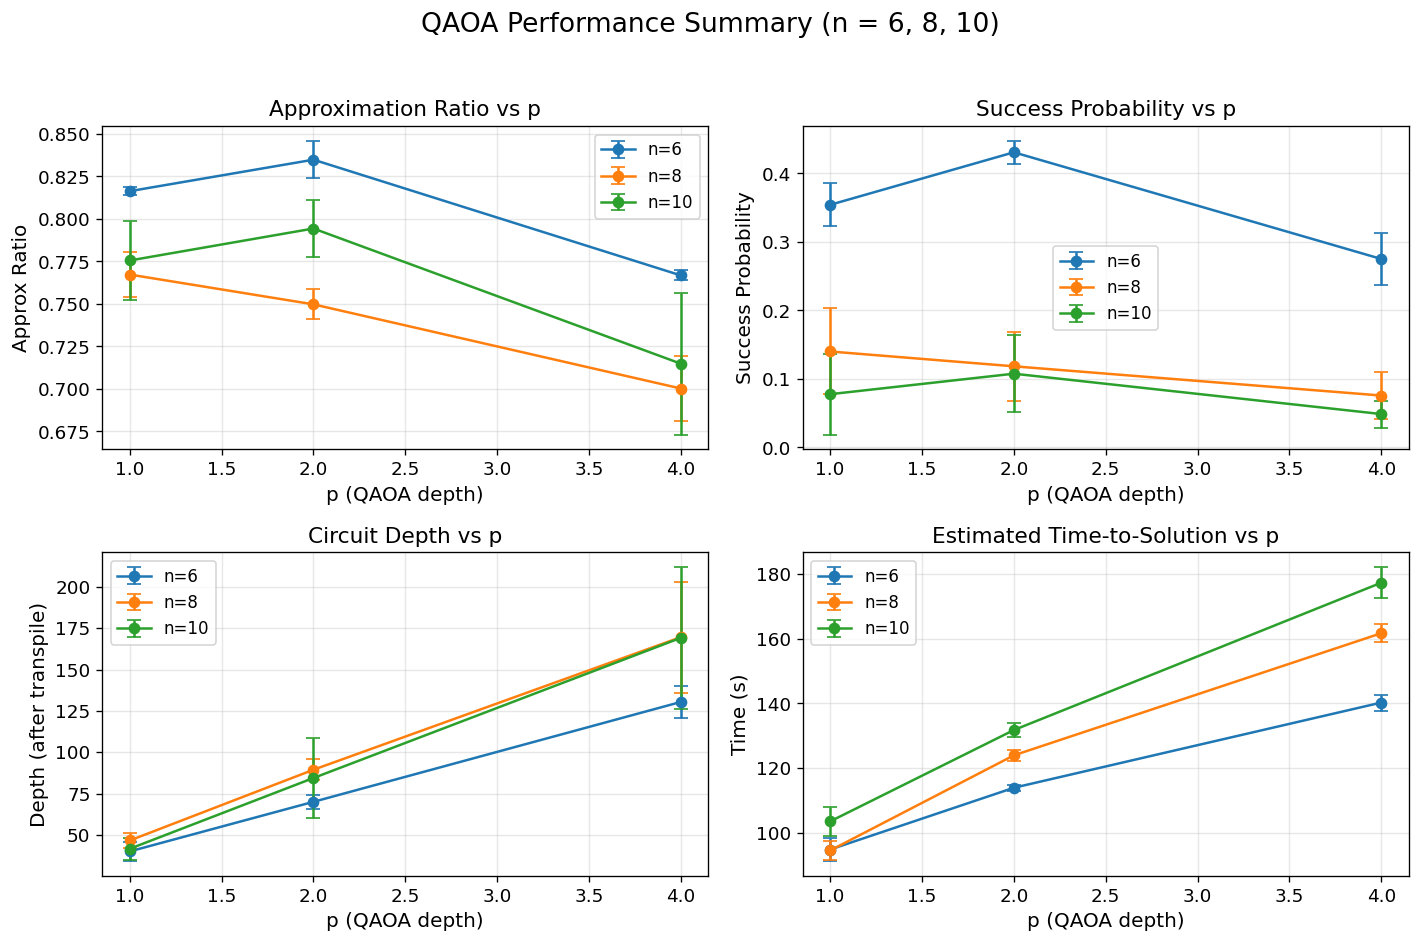

In [20]:
import matplotlib.pyplot as plt

def plot_2x2_all_metrics(agg):
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle("QAOA Performance Summary (n = 6, 8, 10)", fontsize=16, y=0.98)

    plots = [
        ("approx_ratio", "Approximation Ratio vs p", "Approx Ratio"),
        ("success_prob", "Success Probability vs p", "Success Probability"),
        ("depth", "Circuit Depth vs p", "Depth (after transpile)"),
        ("time_est_s", "Estimated Time-to-Solution vs p", "Time (s)")
    ]

    for ax, (metric, title, ylabel) in zip(axs.ravel(), plots):
        df_metric = agg[metric]
        for n in sorted(df_metric["n"].unique()):
            sub = df_metric[df_metric["n"] == n].sort_values("p")
            x = sub["p"].values
            y = sub["mean"].values
            e = sub["std"].values

            ax.errorbar(x, y, yerr=e, fmt='o-', capsize=4, label=f"n={n}")

        ax.set_title(title)
        ax.set_xlabel("p (QAOA depth)")
        ax.set_ylabel(ylabel)
        ax.grid(True, alpha=0.3)
        ax.legend()

    fig.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# ✅ Call it:
plot_2x2_all_metrics(agg)


## 11. Discussion — What I Observe

- **Depth grows with p** (as expected), and routing on a grid introduces additional two-qubit gates.
- **Noise hurts** both approximation ratio and success probability; toggling `USE_NOISE=False` should improve them.
- The **time-to-solution estimate** scales with shots × evaluations × (gate counts), so **optimizer efficiency** and **warm starts** matter a lot.
- With small `n` (like 6–10), I don't expect any realistic *quantum advantage*; this setup is meant to mirror the **trends** and the **overheads** emphasized in the paper rather than prove a speedup.
